In [1]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import requests

In [9]:
def get_meta(body, attr):
    soup = BeautifulSoup(body, parser='lxml')
    metatags = soup.findAll('meta')
    attr_ = [m.get(attr, None) for m in metatags]
    attr = [a.lower() for a in attr_ if a != None]
    
    return np.unique(attr)

In [2]:
df = pd.read_json('/dlabdata1/lugeon/dmozfinalset/dmoz_lang_html.json.gz', orient='records', lines=True)

In [3]:
df.head(1)

,uid,url,html,errcode,content,cat0
0,2424165,www.speech-and-phone.de,"<!DOCTYPE html PUBLIC ""-//W3C//DTD XHTML 1.0 S...",200.0,text/html,Computers


In [4]:
def is_valid(code, content):
    return code == 200 and content.startswith('text/html')

In [5]:
df = df[df.apply(lambda row: is_valid(row.errcode, row.content), axis=1)]

In [6]:
df.shape

(113463, 6)

In [7]:
df = df.sample(10_000, random_state=42)

In [10]:
df['meta_name'] = df.apply(lambda row: get_meta(row.html, 'name'), axis=1)

In [11]:
df.head(1)

,uid,url,html,errcode,content,cat0,meta_name
1201,2143348,www.ibbrugg.ch,<!DOCTYPE html>\n <!--[if IEMobile 7]><html c...,200.0,text/html; charset=utf-8,Computers,"[description, msapplication-tilecolor, msappli..."


In [12]:
cats = df.cat0.unique()

def compute_attr_presence(attr, min_pres):
    all_meta_attr = [] 

    counts = []

    for cat in cats:
        df_cat = df[df.cat0 == cat]
        meta_attrs = df_cat[attr].values
        count = pd.Series([a for b in meta_attrs for a in b]).value_counts() / df_cat.shape[0]
        min_count = count[count >= min_pres]
        counts.append(count)
        all_meta_attr += min_count.index.tolist()
        #print(cat)
        #print(count, '\n')

    all_meta_attr = np.unique(all_meta_attr)
    
    count_array = np.zeros((len(all_meta_attr), len(cats)))
    
    for i in range(len(cats)):
        j = 0
        for attr in all_meta_attr:
            count_array[j,i] = counts[i].get(attr, 0)
            j += 1
        
    return count_array, all_meta_attr
    

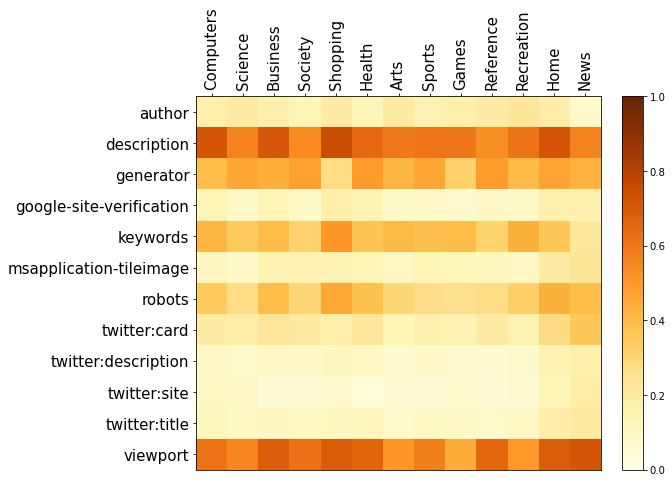

In [26]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

count_attr, attr_names = compute_attr_presence('meta_name', 0.15)

fig, ax = plt.subplots(figsize=(8, 12))

im = plt.imshow(count_attr, cmap='YlOrBr', interpolation='nearest', vmin=0, vmax=1)

plt.xticks(np.arange(len(cats)), cats, rotation=90, fontsize=15)
plt.yticks(np.arange(len(attr_names)), attr_names, fontsize=15)
ax.xaxis.tick_top()

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.3)

plt.colorbar(im, cax=cax)

#ax.title.set_text('Presence of the different kinds of "name" attribute w.r.t to categories'

plt.savefig('metatags_dmoz_lang.png', bbox_inches='tight')

plt.show()

In [23]:
count_attr = 

array([[0.17435897, 0.19893899, 0.16965307, 0.14360119, 0.1875    ,
        0.13959391, 0.20135983, 0.15762712, 0.17337461, 0.1880597 ,
        0.22065064, 0.1761658 , 0.07608696],
       [0.71794872, 0.57029178, 0.70758673, 0.53720238, 0.75138889,
        0.64467005, 0.59884937, 0.60169492, 0.60371517, 0.53432836,
        0.61386139, 0.71502591, 0.56521739],
       [0.38974359, 0.45888594, 0.43423561, 0.47395833, 0.27222222,
        0.49238579, 0.41527197, 0.46271186, 0.32198142, 0.49253731,
        0.40169731, 0.46632124, 0.42391304],
       [0.41794872, 0.35013263, 0.39763629, 0.31547619, 0.50138889,
        0.37055838, 0.40533473, 0.38644068, 0.39628483, 0.31940299,
        0.42998586, 0.3626943 , 0.2173913 ],
       [0.11538462, 0.08222812, 0.15173465, 0.14955357, 0.15138889,
        0.13959391, 0.10094142, 0.13728814, 0.13003096, 0.11641791,
        0.10042433, 0.19689119, 0.22826087],
       [0.34871795, 0.27320955, 0.39268014, 0.30357143, 0.45555556,
        0.37563452, 0.30073

In [15]:
std = []

for i in range(count_attr.shape[0]):
    std.append(np.std(count_attr[i]))
    
sorti = np.argsort(std)[::-1]

print('The presence-feature with the most variance are...')

for i in sorti[:10]:
    print("{:<25} {:.4f}".format(attr_names[i], std[i]))

The presence-feature with the most variance are...
viewport                  0.0844
description               0.0702
keywords                  0.0651
robots                    0.0635
generator                 0.0630
twitter:card              0.0568
twitter:site              0.0395
msapplication-tileimage   0.0383
twitter:title             0.0368
google-site-verification  0.0359


In [32]:
repr_meta = attr_names[sorti[:20]]
repr_meta.tolist()

['viewport',
 'generator',
 'description',
 'twitter:site',
 'twitter:card',
 'robots',
 'keywords',
 'apple-mobile-web-app-capable',
 'google-site-verification',
 'msapplication-tileimage',
 'msvalidate.01',
 'apple-mobile-web-app-status-bar-style',
 'shopify-digital-wallet',
 'handheldfriendly',
 'shopify-checkout-api-token',
 'title',
 'twitter:title',
 'mobileoptimized',
 'author',
 'theme-color']

In [33]:
repr_attributes = ['viewport','generator', 'description', 'twitter:site', 'twitter:card', 'robots', 'keywords', 'apple-mobile-web-app-capable', 'google-site-verification', 'msapplication-tileimage', 'msvalidate.01', 'apple-mobile-web-app-status-bar-style', 'shopify-digital-wallet', 'handheldfriendly', 'shopify-checkout-api-token', 'title', 'twitter:title', 'mobileoptimized', 'author', 'theme-color']

In [39]:
def embed_metatags(soup):
    metatags = soup.findAll('meta')
    attr = [m.get('name', None) for m in metatags]
    attr = [a.lower() for a in attr if a != None]
    
    attr_emb = [int(a in attr) for a in repr_attributes]
    
    return attr_emb

In [42]:
r = requests.get('https://www.bbc.com')
soup = BeautifulSoup(r.text, parser='lxml')

In [43]:
embed_metatags(soup)

[1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]